# Boston Marathon Clustering
Raj Prasad
June 2019

[html version](https://daddyprasad5.github.io/boston_marathon_clustering.html) - with all the code hidden away for a quick read

[jupyter notebook version](https://github.com/daddyprasad5/thinkful/blob/master/boston_marathon_clustering.ipynb) - with all the code exposed in an interactive notebook



I'll explore kmeans (for numeric features only), kmodes (for categorical features only) and kprototypes for a combination of categorical and numeric.  

In [73]:
#imports
    
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import time
%matplotlib inline

In [74]:
#load the data
#https://github.com/llimllib/bostonmarathon/blob/master/results/2014/results.csv
bm_df = pd.read_csv("results.csv")

In [75]:
bm_df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [429]:
bm_df.describe()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,5k,half,20k,40k
count,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000
mean,51.807495,1932.563032,133.771696,42.407079,242.997314,8051.044741,196.870568,15939.587825,9.275658,25.759957,111.685348,105.735206,229.056082
std,8.966371,1715.228694,25.654304,11.316496,52.300431,4754.005626,41.977707,9232.978224,1.992486,4.329492,21.059566,19.786613,49.188769
min,16.620000,1.000000,45.800000,18.000000,80.600000,1.000000,67.420000,1.000000,3.080000,7.750000,38.030000,36.100000,76.100000
25%,45.400000,610.000000,115.550000,33.000000,205.527500,3972.000000,167.130000,7943.750000,7.850000,22.650000,96.850000,91.770000,193.830000
50%,50.350000,1425.000000,129.030000,42.000000,232.370000,7970.000000,188.180000,15939.500000,8.870000,25.100000,107.870000,102.180000,218.880000
75%,57.180000,2611.000000,148.080000,50.000000,273.235000,11968.000000,220.180000,23935.250000,10.430000,28.480000,123.080000,116.550000,257.530000
max,112.380000,6979.000000,289.020000,81.000000,538.880000,17575.000000,449.330000,31931.000000,20.570000,86.950000,236.670000,224.350000,508.350000


In [76]:
bm_df.describe(include=['O'])

,10k,name,25k,gender,bib,ctz,35k,state,30k,5k,half,20k,country,city,40k
count,31984,31984,31984,31984,31984,1244,31984,29408,31984,31984,31984,31984,31984,31983,31984
unique,2766,31915,6570,2,31984,84,9516,68,8090,1491,5651,5375,78,5934,10546
top,-,"Jones, David",-,M,17329,GBR,-,MA,-,23.93,-,-,USA,Boston,-
freq,50,2,216,17617,1,171,34,7587,40,81,72,51,27233,1034,39


In [430]:
bm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 17 columns):
10k          31984 non-null float64
division     31984 non-null int64
25k          31984 non-null float64
gender       31984 non-null category
age          31984 non-null float64
official     31984 non-null float64
genderdiv    31984 non-null int64
35k          31984 non-null float64
overall      31984 non-null int64
pace         31984 non-null float64
state        31984 non-null object
30k          31984 non-null object
5k           31984 non-null float64
half         31984 non-null float64
20k          31984 non-null float64
country      31984 non-null category
40k          31984 non-null float64
dtypes: category(2), float64(10), int64(3), object(2)
memory usage: 3.7+ MB


In [77]:
#change column types - make categorical values categorical, numerics numeric etc.
bm_df.columns

catcols = ["gender", "ctz", "state", "country", "city"]

floatcols = ["10k", "25k", "age", "35k", "pace", "5k", 
            "half", "20k", "40k", "official"]

intcols = ["age", "genderdiv", "division"]

contcols = []
contcols.extend(floatcols)
contcols.extend(intcols)

for cat in catcols: 
    bm_df[cat] = bm_df[cat].astype("category")
    
for floatcol in floatcols: 
    bm_df[floatcol].replace("-", None, inplace=True)
    bm_df[floatcol] = bm_df[floatcol].astype("float64")


In [78]:
#look for missing values

def find_nulls(df): 
    total_missing = df.isnull().sum().sort_values(ascending=False)
    percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    return pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])

find_nulls(bm_df)
 

,Total,Percent
ctz,30740,0.961106
state,2576,0.080540
city,1,0.000031
40k,0,0.000000
genderdiv,0,0.000000
name,0,0.000000
division,0,0.000000
25k,0,0.000000
gender,0,0.000000
age,0,0.000000


There are very few filled ctx values, so let's drop this column. 

There are nearly 6000 unique cities - so let's drop this feature as not useful for clustering

I'll fill the missing state values with "other"

In [79]:
#deal with missing values per above
bm_df.state = bm_df.state.astype("object")
bm_df.state.fillna("other", inplace=True)
bm_df.drop(["ctz", "city", "name", "bib"], axis=1, inplace=True)
find_nulls(bm_df)

,Total,Percent
40k,0,0.0
35k,0,0.0
division,0,0.0
25k,0,0.0
gender,0,0.0
age,0,0.0
official,0,0.0
genderdiv,0,0.0
overall,0,0.0
country,0,0.0


In [433]:
contcols

['10k', '25k', 'age', '35k', 'pace', '5k', 'half', '20k', '40k', 'official']

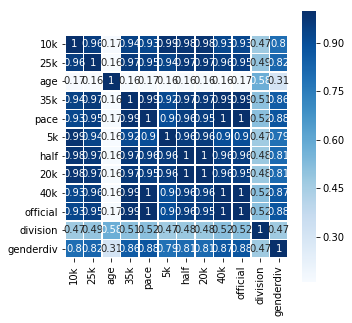

In [437]:
#define candidate continuous features and peak at the pair-wise correlation matrix
X = bm_df.loc[:, ['10k', '25k', 'age', '35k', 'pace', '5k', 'half', '20k', '40k', 'official', 'division', 'genderdiv']]
plt.figure(figsize=(5,5))
g=sns.heatmap(X.corr().applymap(abs), square=True, annot=True, linewidths=.5, cmap="Blues")


The time features and "genderdiv" are all so highly correlated, that it's not likely to be very useful to include them all as features.  Let's just use the age, division and one timing measure:  official time. 

In [452]:
#let's try kmean first - just on continuous columns

X = bm_df.loc[:, ["age", "division", "official"]]

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Normalize
X_norm = normalize(X)

# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        km = KMeans(n_clusters=nclust, random_state=42)
        pred = km.fit_predict(data[0])
        print("cluster centers for k = {}: {}".format(nclust, km.cluster_centers_))
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

cluster centers for k = 2: [[0.03375185 0.97521192 0.17681966]
 [0.1901934  0.5132836  0.78405291]]
cluster centers for k = 3: [[0.02511365 0.98661199 0.14033706]
 [0.11160857 0.84519136 0.50101404]
 [0.2224309  0.33931599 0.89044731]]
cluster centers for k = 4: [[0.02033943 0.99093573 0.11966594]
 [0.15566572 0.71093396 0.67235855]
 [0.2350293  0.25178772 0.92639397]
 [0.07555786 0.92704232 0.35555821]]
cluster centers for k = 2: [[0.03342819 0.97577689 0.1752154 ]
 [0.19068541 0.50973996 0.78710313]]
cluster centers for k = 3: [[0.02513481 0.98664562 0.14003028]
 [0.2224523  0.34319993 0.88880502]
 [0.11024164 0.84662937 0.49833776]]
cluster centers for k = 4: [[0.01935399 0.99171897 0.11484267]
 [0.15372639 0.71287101 0.67038397]
 [0.2348307  0.25813525 0.92377857]
 [0.07095211 0.93465647 0.33625725]]
cluster centers for k = 2: [[0.03285351 0.97632366 0.17264337]
 [0.18712701 0.52448695 0.77725093]]
cluster centers for k = 3: [[0.02490002 0.98673874 0.13902588]
 [0.22254993 0.339539

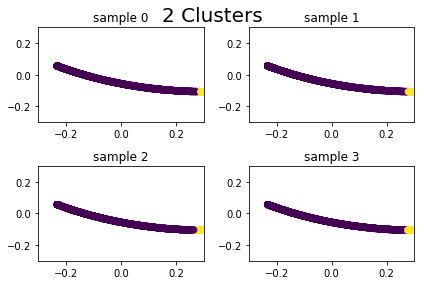

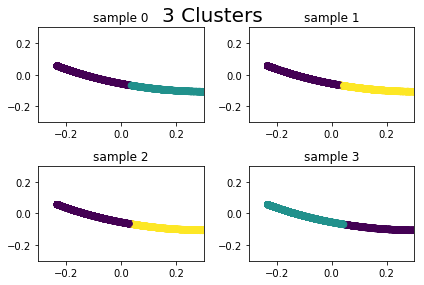

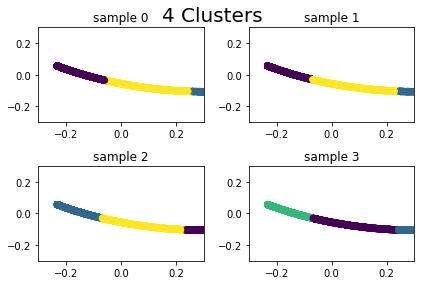

In [439]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

Visually the clusters are very consistent across samples, for k=2, 3 and 4. 

Let's look at some descriptive statistics for each as well.  We'll compare the means for each column/centroid/sample and they should be fairly consistent. 

In [441]:
#create a sample dataframe for each sample, with the predicted centroid added as a column each for k=2,3,4
numcentroids = [2,3,4]

sample1 = pd.DataFrame(X1)
sample2 = pd.DataFrame(X2)
sample3 = pd.DataFrame(X3)
sample4 = pd.DataFrame(X4)
sample1.columns = sample2.columns = sample3.columns = sample4.columns = X.columns


for numcentroid in numcentroids:
    sample1["centroid_{}".format(numcentroid)] = ypred['clust{}_sample{}'.format(numcentroid, 0)]
    sample2["centroid_{}".format(numcentroid)] = ypred['clust{}_sample{}'.format(numcentroid, 1)]
    sample3["centroid_{}".format(numcentroid)] = ypred['clust{}_sample{}'.format(numcentroid, 2)]
    sample4["centroid_{}".format(numcentroid)] = ypred['clust{}_sample{}'.format(numcentroid, 3)]



In [442]:
#function for calcluating the means of a given feature of all obs for each centroid
def get_means2(numcentroid, col, s, sample): 
    us = []
    for centroid in range(0, numcentroid): 
        us.append(sample.loc[sample["centroid_{}".format(numcentroid)] == centroid, col].mean())
        us.sort()
    return us



In [445]:
#calculate the mean values for each column, centroid and sample

samples = [sample1, sample2, sample3, sample4]
contcols = ['age', 'division','official']
            
means2_df = pd.DataFrame({"numcentroid": [], "col": [], "sample": [], "mean1": [], "mean2": [], "mean3": [], "mean4": []})

for numcentroid in numcentroids:
    for col in contcols:
        for s, sample in enumerate(samples):
            us = get_means2(numcentroid, col, s, sample)
            if len(us) == 4:
                means2_df.loc[i] = [numcentroid, col, s, us[0], us[1], us[2], us[3]]
            elif len(us) == 3:
                means2_df.loc[i] = [numcentroid, col, s, us[0], us[1], us[2], None]
            else:
                means2_df.loc[i] = [numcentroid, col, s, us[0], us[1], None, None]
            i+=1
            
            

,numcentroid,col,sample,variable,value
0,2.0,age,0.0,mean1,0.0337518
1,2.0,age,1.0,mean1,0.0334377
2,2.0,age,2.0,mean1,0.0328701
3,2.0,age,3.0,mean1,0.0331605
4,2.0,division,0.0,mean1,0.513284


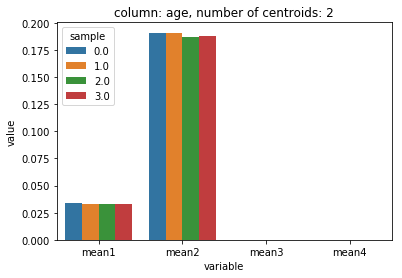

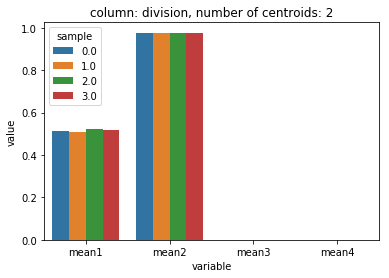

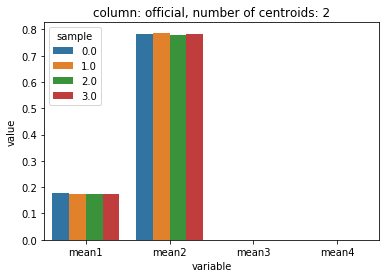

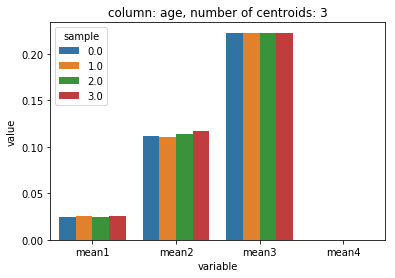

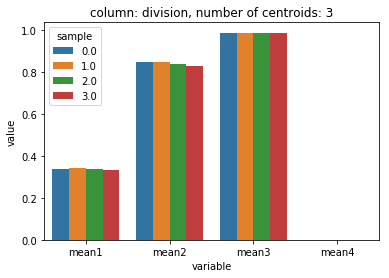

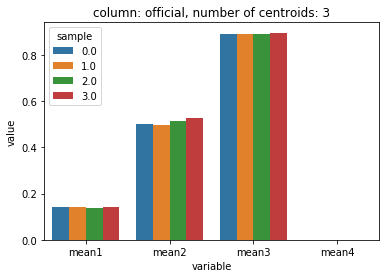

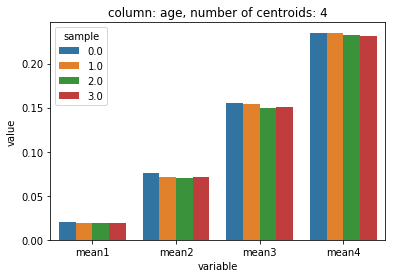

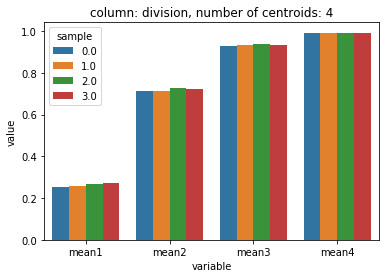

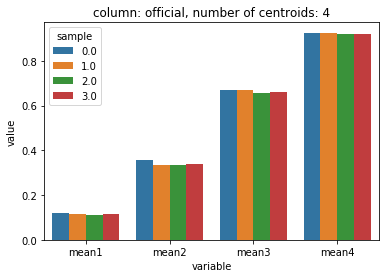

In [447]:
#graph the means across samples for each column and trial
melted_means = pd.melt(means2_df, id_vars=['numcentroid', "col", "sample"], value_vars=['mean1', 'mean2', 'mean3', 'mean4'])

display(melted_means.head())

for numcentroid in [2,3,4]:
    for col in melted_means.col.unique():
        data=melted_means[(melted_means.col == col) & (melted_means.numcentroid == numcentroid)]
        ax = sns.barplot(y="value", x="variable", hue="sample", data=data)
        ax.set_title("column: {}, number of centroids: {}".format(col, numcentroid))
        plt.show()


The means of the obs assigned to a given centroid are consistent across samples, for k= 2, 3 and 4. 

## K-modes, and K-Prototypes

But that's just using the continuous variables.  What about all the nice categorical data we have about the runners?  

Per Tim Goodman on stack exchange, "The standard k-means algorithm isn't directly applicable to categorical data, for various reasons. The sample space for categorical data is discrete, and doesn't have a natural origin. A Euclidean distance function on such a space isn't really meaningful."

Fortunately there's a [nice implemenation called "k-modes"](https://github.com/nicodv/kmodes#huang97), based on [a paper by Zhexue Huang](http://www.cs.ust.hk/~qyang/Teaching/537/Papers/huang98extensions.pdf).  The same module also implements "k-prototypes" which allows both categorical and continuous variables.  

Let's try them both out.  

In [384]:
#let's try out kmodes, a clustering method for categorical data.  The print out are the centroids for k=2-6.

from kmodes.kmodes import KModes

for k in [2,3,4,5,6]:
    X = bm_df.loc[:, ["gender", "state", "country"]]
    km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0)
    clusters = km.fit_predict(X)
    # Print the cluster centroids
    print(km.cluster_centroids_)

[['F' 'MA' 'USA']
 ['M' 'MA' 'USA']]
[['M' 'MA' 'USA']
 ['F' 'MA' 'USA']
 ['M' 'other' 'GBR']]
[['M' 'other' 'CAN']
 ['F' 'MA' 'USA']
 ['M' 'CA' 'USA']
 ['M' 'MA' 'USA']]
[['F' 'NY' 'USA']
 ['M' 'CA' 'USA']
 ['M' 'other' 'GBR']
 ['F' 'MA' 'USA']
 ['M' 'MA' 'USA']]
[['M' 'MA' 'USA']
 ['F' 'MA' 'USA']
 ['F' 'CA' 'USA']
 ['M' 'other' 'GBR']
 ['F' 'IL' 'USA']
 ['M' 'KY' 'USA']]


In [421]:
#get a sense for the most common permutations of gender, state, country
cnt = [1] * len(X)
gr = X.copy()
gr = gr.groupby(["gender", "state", "country"])
gr_names = []
gr_counts = []
for name, group in gr: 
    gr_names.append(name)
    gr_counts.append(len(group))

gr_counts = pd.DataFrame({"group": gr_names, "count":gr_counts})
gr_counts.sort_values(by="count", ascending=False).head(30)

,group,count
23,"(F, MA, USA)",3929
152,"(M, MA, USA)",3658
136,"(M, CA, USA)",1225
8,"(F, CA, USA)",1101
172,"(M, NY, USA)",878
43,"(F, NY, USA)",675
175,"(M, ON, CAN)",573
177,"(M, PA, USA)",558
186,"(M, TX, USA)",537
147,"(M, IL, USA)",519


In [428]:
#lets try a combination of categorical and continuous variables with "k-prototypes"

from kmodes.kprototypes import KPrototypes
X = bm_df.loc[:, ["gender", "state", "country", "age", "official"]]

kproto = KPrototypes(n_clusters=4, init='Cao', verbose=2)
clusters = kproto.fit_predict(X, categorical=[0,1,2])
# Print the cluster centroids
print(kproto.cluster_centroids_)


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 4491, ncost: 15388609.394755345
Run: 1, iteration: 2/100, moves: 1700, ncost: 15239535.220106948
Run: 1, iteration: 3/100, moves: 648, ncost: 15216455.449467681
Run: 1, iteration: 4/100, moves: 228, ncost: 15210872.739666332
Run: 1, iteration: 5/100, moves: 121, ncost: 15208821.383526687
Run: 1, iteration: 6/100, moves: 109, ncost: 15207661.531135144
Run: 1, iteration: 7/100, moves: 101, ncost: 15206998.665678842
Run: 1, iteration: 8/100, moves: 71, ncost: 15206592.946367431
Run: 1, iteration: 9/100, moves: 50, ncost: 15206370.833857423
Run: 1, iteration: 10/100, moves: 49, ncost: 15206130.630206091
Run: 1, iteration: 11/100, moves: 28, ncost: 15206053.734884707
Run: 1, iteration: 12/100, moves: 20, ncost: 15206013.153481184
Run: 1, iteration: 13/100, moves: 16, ncost: 15205978.59996814
Run: 1, iteration: 14/100, moves: 9, ncost: 15205970.135560771
Run: 1, iteration: 15/100,

Run: 6, iteration: 5/100, moves: 2128, ncost: 15560706.896222504
Run: 6, iteration: 6/100, moves: 1482, ncost: 15408519.222639667
Run: 6, iteration: 7/100, moves: 1105, ncost: 15320291.372139271
Run: 6, iteration: 8/100, moves: 801, ncost: 15271372.626876973
Run: 6, iteration: 9/100, moves: 588, ncost: 15246218.582400052
Run: 6, iteration: 10/100, moves: 449, ncost: 15231282.06561236
Run: 6, iteration: 11/100, moves: 383, ncost: 15220048.294652745
Run: 6, iteration: 12/100, moves: 297, ncost: 15213521.501728961
Run: 6, iteration: 13/100, moves: 223, ncost: 15210197.141402513
Run: 6, iteration: 14/100, moves: 152, ncost: 15208329.99685563
Run: 6, iteration: 15/100, moves: 108, ncost: 15207455.832837628
Run: 6, iteration: 16/100, moves: 92, ncost: 15206879.163936745
Run: 6, iteration: 17/100, moves: 72, ncost: 15206509.815869913
Run: 6, iteration: 18/100, moves: 49, ncost: 15206282.948286498
Run: 6, iteration: 19/100, moves: 43, ncost: 15206095.57756091
Run: 6, iteration: 20/100, moves: 

Run: 10, iteration: 26/100, moves: 8, ncost: 15205911.72246454
Run: 10, iteration: 27/100, moves: 4, ncost: 15205910.373791514
Run: 10, iteration: 28/100, moves: 3, ncost: 15205909.804258317
Run: 10, iteration: 29/100, moves: 0, ncost: 15205909.804258317
Best run was number 6
[array([[ 38.33059911, 190.0472412 ],
       [ 44.31249141, 282.52945032],
       [ 44.30189162, 231.41564673],
       [ 43.35239521, 350.24559281]]), array([['M', 'other', 'USA'],
       ['F', 'MA', 'USA'],
       ['F', 'MA', 'USA'],
       ['F', 'MA', 'USA']], dtype='<U5')]


The k-mode seemed to do a decent job of identifying centroids that were "far apart" from each other yet of similar size. 

The k-prototype barely used the categorical variables - 3 of the 4 centroids had the same value on all 3 categorical dimensions, and all 4 centroids were the same on country.  

There is a a parameter "gamma" that is a weighing factor that determines relative importance of numerical vs. categorical attributes.  Let's play with that to see if we can't over-weight the categorical values.

In [460]:
X = bm_df.loc[:, ["gender", "state", "country", "age", "official"]]

kproto = KPrototypes(n_clusters=4, init='Cao', n_init=4, n_jobs=2, verbose=2, gamma=10000)
clusters = kproto.fit_predict(X, categorical=[0,1,2])
# Print the cluster centroids
print(kproto.cluster_centroids_)

Best run was number 1
[array([[ 43.22644795, 201.83093383],
       [ 40.15546724, 225.86926903],
       [ 39.8093479 , 293.61118696],
       [ 46.37068175, 285.23468205]]), array([['M', 'other', 'USA'],
       ['F', 'CA', 'USA'],
       ['F', 'MA', 'USA'],
       ['M', 'MA', 'USA']], dtype='<U5')]
